# Artifical Neural Network using Multilayer Perceptron
## Jade Gee
---
---

## Background

<font size="3">Deep Neural Networks were inspired by biological neurons. Biological neurons receive signals through the dendrites and send them through to the nucleus for stimulation which then, depending on the signal type, activate a signal that goes through the axiom.

![Neurons](neurons.png)

Like a biological neuron, the artificial neuron takes weighted inputs that go into the dendrites and stimulate the nucleus which then cause the axiom to fire. These artifical neurons form our neural networks and produce extremely complex functions.

---
## Gather the Data

For the purpose of this Neural Network, we are going to be using the MNIST data from the `MLDatasets` package. This dataset comes from the **MNIST Database** from the National Institute of Standards and Technology, and is considered to be one of the largest databases of handwritten digits that are typically used for training and testing data in machine learning. An example of the data in the MNIST database can be found below, and for additional information regarding the MNIST data, please look [here](https://en.wikipedia.org/wiki/MNIST_database).
    
  ![MNISTexample](mnistExample.png)

We will also need the following packages to access and display the data: </font>

<font size="4">+ `MLDatasets` </font>
<br><font size="3">
> [Documentation](https://juliaml.github.io/MLDatasets.jl/latest/)</font>
    
<font size="4">+ `Images`, `TestImages`, `ImageMagick`</font>
<br> <font size="3">
> [Images Documentation](https://juliaimages.org/stable/)
<br>
> [TestImages Docuentation](https://testimages.juliaimages.org/)
<br>
> [ImageMagick Documentation](https://imagemagick.org/)
    
 </font>

In [3]:
using MLDatasets
using Images
using TestImages
using Plots

---

### Gather the data

<font size="3">The first step we must take is to designate our training and testing data as shown in the following code cell.</font>

The first image in our train data is labeled 5


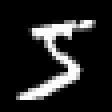

In [4]:
train_x, train_y = MNIST.traindata();
test_x, test_y = MNIST.testdata();

println("The first image in our train data is labeled ", train_y[1])
colorview(Gray, train_x[:, :, 1]')

The data structures `train_x` and `train_y` are stored as 3-dimensional tensors of dimensions: $28 \times 28 \times 60000$. The images in the data set are stored as $28 \times 28$ grey scaled grid  of pixel values.

In order to pass these images into our neural network, we must flatten the training matrices into vectors as shown below.

In [5]:
X = []
Y = []

for i = 1:60000
    push!(X, reshape(train_x[:, :, i], 784))
    y = zeros(10)
    y[train_y[i] + 1] = 1.0
    push!(Y, y)
end

train_data = [x for x in zip(X, Y)];
print(typeof(train_data))
println("\n")

X2 = []
Y2 = []

for i = 1:10000
    push!(X2, reshape(test_x[:, :, i], 784))
    y2 = zeros(10)
    y2[test_y[i] + 1] = 1.0
    push!(Y2, y2)
end

test_data = [x for x in zip(X2, Y2)];
print(typeof(test_data))

Array{Tuple{Array{Normed{UInt8,8},1},Array{Float64,1}},1}

Array{Tuple{Array{Normed{UInt8,8},1},Array{Float64,1}},1}

---
## Building the Network Architecture

<font size="3">We are using a multilayered perceptron model that contains $L$ layers, $784$ input neurons, $L-2$ hidden layers of an arbitrary size, and $10$ neurons in the output layer. Our activation function will utilize the sigmoid function.

+ Sigmoid Function:

    $$\sigma(x) = \frac{1}{1+e^{-x}}$$

<br>

![MultilayeredPerceptron](multi_p.png)

For $l=2$,... , $L$, each layer $l$ in our network will have two phases, the pre-activation phase

$$ z^l = W^l a^{l-1} + b^l, $$ 
and the post-activation phase 
$$ a^l = \sigma(z^l). $$

The pre-activation phase consists of a weighted linear combination of post-activation values int he previous layer while the post-activation values consists of passing the pre-activation value through an activation function element-wise. ($ a^1 = x^{(i)}$, where $x^{(i)}$ is the current input feature vector of our network.

For a given instance, $(x^{(i)}, y^{(i)})$, we will use the Mean Square Error cost: 
$$ C = C(W, b) = \frac{1}{2} \sum_{k=1}^n (a_k^L - y_k^{(i)})^2,$$
where $n=10$ is the size of the output layer. </font>

In [6]:
# Activation function and its derivative definitions
σ(x) = 1.0/(1.0 + exp(-x))

∂σ(x) = σ(x)*(1 - σ(x))


#Define a neural network type
mutable struct neural_network
    #Attributes
    WeightMatrix
    biasMatrix
end

# Initialize weights an biases
function create_network(inputLayer_Size, hiddenLayer_sizes, outputLayer_size)
    WeightMatrix = [[0.0], randn(hiddenLayer_sizes[1], inputLayer_Size)]
    biasMatrix = [[0.0], randn(hiddenLayer_sizes[1])]
    
    for i = 2:length(hiddenLayer_sizes)
        push!(WeightMatrix, randn(hiddenLayer_sizes[i], hiddenLayer_sizes[i-1]))
        push!(biasMatrix, randn(hiddenLayer_sizes[i]))
    end
    
    push!(WeightMatrix, randn(outputLayer_size, hiddenLayer_sizes[end]))
    push!(biasMatrix, randn(outputLayer_size))
    
    return neural_network(WeightMatrix, biasMatrix)
end

create_network (generic function with 1 method)

<font size="3">With our network function built, we can now create our neural network with four (4) hidden layers of size $150$ and output layer of size $15$. </font>

In [24]:
NN = create_network(784, [150, 150, 150, 150], 15);
NN.WeightMatrix;
NN.biasMatrix;


# Prints the size of the hidden layers
for w in NN.WeightMatrix
    println(size(w))
    println("---------")
end

(1,)
---------
(150, 784)
---------
(150, 150)
---------
(150, 150)
---------
(150, 150)
---------
(15, 150)
---------


<font size="3"> As we have successfully built our neural network above, we can now begin building the algorithm's infrastructure. To do this, we need several functions to proceed:
    
   + **Forward Pass function**
    
        - To pass a given training feature set into the input layer along with a bias neuron
    
   + **Prediction function**
    
        - To predict the label of the test image
    
   + **Success Percentage Calculator Function**; and an
    
        - To determine the accuracy of our neural network
    
   + **Error function**
        - To calculate the output errors and hidden layer errors
</font>

In [8]:
function forwardPass(network::neural_network, trainingInstance)
    Z = [[0.0]] #preactivation values
    A = [trainingInstance[1]] #postactivation values
    for i = 2:length(network.WeightMatrix)
        push!(Z, network.WeightMatrix[i]*A[i-1] + network.biasMatrix[i])
        push!(A, σ.(Z[i]))
    end
    return Z, A
end

function prediction(network::neural_network, trainingInstance)
    Z, A = forwardPass(network, trainingInstance)
    return (argmax(A[end]) - 1)
end

function successPercent(network::neural_network, dataset)
    return string("Percentage of correctly classified images is: ",
        (sum([prediction(network, x) == argmax(x[2]) - 1 ? 1 : 0 for x in dataset])/length(dataset))*100., " %")
end


# Calculate output errors and hidden layer errors
function error_deltas(network, trainingInstances)
    Z, A = forwardPass(network, trainingInstances)
    L = size(network.WeightMatrix)[1]
    δ = [(A[end] - trainingInstances[2]).*∂σ.(Z[end])]
    
    for i = L-1:-1:2
        pushfirst!(δ, (network.WeightMatrix[i+1]'*δ[1]).*∂σ.(Z[i]))
    end
    pushfirst!(δ, [0.0])
    return A, δ
end

forwardPass (generic function with 1 method)

In [10]:
#Test the success percentage
successPercent(NN, test_data)

"Percentage of correctly classified images is: 13.16 %"

In [12]:
# Test the errors function
A_test, δ_test = error_deltas(NN, train_data[1])

(Array{Normed{UInt8,8},1}[[0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8  …  0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8], [0.09N0f8, 0.353N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.871N0f8, 0.0N0f8, 0.059N0f8, 0.0N0f8, 1.0N0f8  …  1.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.973N0f8, 1.0N0f8, 0.008N0f8, 0.702N0f8, 0.016N0f8, 1.0N0f8], [0.11N0f8, 1.0N0f8, 0.565N0f8, 0.996N0f8, 0.984N0f8, 0.008N0f8, 0.024N0f8, 0.478N0f8, 0.992N0f8, 0.055N0f8  …  0.02N0f8, 0.0N0f8, 0.212N0f8, 0.055N0f8, 0.663N0f8, 0.502N0f8, 0.063N0f8, 0.996N0f8, 0.0N0f8, 0.0N0f8], [1.0N0f8, 0.157N0f8, 0.733N0f8, 0.62N0f8, 0.953N0f8, 1.0N0f8, 0.173N0f8, 0.588N0f8, 0.004N0f8, 0.8N0f8  …  0.953N0f8, 0.043N0f8, 0.0N0f8, 0.0N0f8, 0.027N0f8, 0.02N0f8, 1.0N0f8, 0.051N0f8, 1.0N0f8, 0.239N0f8], [0.949N0f8, 1.0N0f8, 0.0N0f8, 0.204N0f8, 0.502N0f8, 0.047N0f8, 0.639N0f8, 0.71N0f8, 0.537N0f8, 1.0N0f8]], [[0.0], [0.014907379270048957, 0.07048679272644597, 5.71074

---
### Train the network

<font size="3"> With our functions properly working, we can now delve into training the network for better accuracy. As such we will need to create a random batch of data, or mini batch, and build a function that will update the neural network based on the errors that are generated. The update function will update the weights and biases by utilizing stochastic gradient descent by recursively calculating the gradient of the cost function: 


$$C(W,b) = \frac{1}{2} \sum_{k=1}^n (a_k^L - y_k^{(i)})^2 = \frac{1}{2} (a_1^3 - y_1^{(i)})^2 + \frac{1}{2} (a_2^3 - y_2^{(i)})^2 $$

<br>
To do this, we will focus on the output error:

$$
\delta_j^L = \frac{\partial C}{\partial a_j^L}\sigma'(z_j^L),
$$
    
where the pre-activation value is denoted by $z_j^L$, at neuron $j$, and output error $L$. With this in mind, we will proceed to create our miniature batch and mini batch update functions, as well as our functions that will aid in displaying the results and the test image for testing purposes. </font>

In [13]:
function make_random_miniBatch(miniBatch_size, dataset)
    k = rand(1:size(dataset)[1] - miniBatch_size)
    return dataset[k:k + miniBatch_size]
end

function miniBatch_update!(network::neural_network, miniBatch_size::Int64, dataset, α::Float64)
    
    minibatch = make_random_miniBatch(miniBatch_size, dataset)
    L = size(network.WeightMatrix)[1]
    
    A, δ = error_deltas(network, minibatch[1])
    A_batch = []
    δ_batch = []
    push!(A_batch, A)
    push!(δ_batch, δ)
    
    for i = 2:miniBatch_size # began at 2:
        A, δ = error_deltas(network, minibatch[i])
        push!(A_batch, A)
        push!(δ_batch, δ)
    end
    
    for l = L:-1:2
        network.WeightMatrix[l] -= (α/miniBatch_size)*sum([δ_batch[i][l]*A_batch[i][l-1]' for i = 1:miniBatch_size])
        network.biasMatrix[l] -= (α/miniBatch_size)*sum([δ_batch[i][l] for i = 1:miniBatch_size])
    end
end

function showTestImg(i)
    colorview(Gray, test_x[:,:,i]')
end

function showTest_example(network, i, test_data)
    println("Predict Label: ", prediction(network, test_data[i]))
    println("Actual Label: ", argmax(test_data[i][2])-1)
    showTestImg(i)
end

miniBatch_update! (generic function with 1 method)

---
### Test the data

<font size="3"> To ensure that all of our functions are working properly, we will implement and test our deep neural network on the MNIST test data as seen in the following code cells.</font>

Percentage of correctly classified images is: 13.16 %


Predict Label: 0
Actual Label: 9


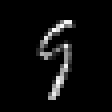

In [15]:
println(successPercent(NN, test_data), "\n\n")
i = rand([x for x = 1:10000])
showTest_example(NN, i, test_data)

<font size="3"> As our success percentage is still low, we will update our function and run it again to ensure better accuracy. </font>

Percentage of correctly classified images is: 75.82 %


Predict Label: 9
Actual Label: 7


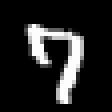

In [16]:
for _ = 1:10000
    miniBatch_update!(NN, 2, train_data, 0.4)
end

println(successPercent(NN, test_data), "\n\n")
i = rand([x for x = 1:10000])
showTest_example(NN, i, test_data)

<font size="3"> Now we can see that the update was successful since the success percentage made a significant increase. We will continue to update our function and run more tests to attempt to get our network within 90% of successfully classified images. </font>

Percentage of correctly classified images is: 89.55 %


Predict Label: 6
Actual Label: 6


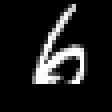

In [17]:
for _ = 1:10000
    miniBatch_update!(NN, 2, train_data, 0.4)
end

println(successPercent(NN, test_data), "\n\n")
i = rand([x for x = 1:10000])
showTest_example(NN, i, test_data)

Percentage of correctly classified images is: 91.28 %


Predict Label: 5
Actual Label: 5


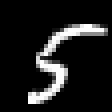

In [18]:
for _ = 1:10000
    miniBatch_update!(NN, 2, train_data, 0.4)
end

println(successPercent(NN, test_data), "\n\n")
i = rand([x for x = 1:10000])
showTest_example(NN, i, test_data)

---
---
## Conclusion

<font size="3">With our neural network within the 90% accuracy, we can see that we have built a successful neural network that predicts the label of our test images. </font>

---

### For additional information, please see the following:
<br>
<font size="3">

+ [Artifical Neural Network - Wikipedia](https://en.wikipedia.org/wiki/Artificial_neural_network)
<br>
    
+ [Neural Network & Deep Learning](http://neuralnetworksanddeeplearning.com/)
<br>

+ [Understanding Neural Networks](https://towardsdatascience.com/understanding-neural-networks-19020b758230)
    
</font>

---
---